<a href="https://colab.research.google.com/github/namvux1404/Anomalies-detection---Vector-workshop/blob/Nam/Multivariate_timeseries_anomalies_GDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multivariate timeseries anomalies detections using Graph Deviation Network (GDN)

References:
- GDN (paper): https://arxiv.org/pdf/2106.06947.pdf
- GDN (github): https://github.com/d-ailin/GDN
- telemanom (paper): https://arxiv.org/pdf/1802.04431.pdf
- telemanom (github): https://github.com/khundman/telemanom/tree/master
- Graph visualization (github): https://github.com/shahaamirbader/GDN

##1. Setup and install requirements

Download the GDN code from gitHub

In [1]:
!git clone https://github.com/d-ailin/GDN.git

Cloning into 'GDN'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 54 (delta 10), reused 6 (delta 6), pack-reused 27
Receiving objects: 100% (54/54), 473.31 KiB | 539.00 KiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
!git clone https://github.com/namvux1404/Anomalies-detection---Vector-workshop.git

Cloning into 'Anomalies-detection---Vector-workshop'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 187 (delta 55), reused 68 (delta 32), pack-reused 77
Receiving objects: 100% (187/187), 1.51 MiB | 942.00 KiB/s, done.
Resolving deltas: 100% (77/77), done.


Update python file due to Pytorch-geometric lib version issue from our folder

In [3]:
#modify graph_layer.py
%cp /content/Anomalies-detection---Vector-workshop/modified_pyFile/graph_layer.py /content/GDN/models/graph_layer.py

#modify main.py
%cp /content/Anomalies-detection---Vector-workshop/modified_pyFile/main.py /content/GDN/main.py

#modify evaluate.py
%cp /content/Anomalies-detection---Vector-workshop/modified_pyFile/evaluate.py /content/GDN/evaluate.py

#add python file for graph image
%cp /content/Anomalies-detection---Vector-workshop/modified_pyFile/graph_visualization.py /content/GDN/graph_visualization.py

#modify run.sh
%cp /content/Anomalies-detection---Vector-workshop/modified_pyFile/run.sh /content/GDN/run.sh


In [4]:
import os
os.chdir('./GDN/')

In [5]:
import torch
## check PyTorch version
print(torch.__version__)

2.0.1+cu118


Install necessary libs for GDN

In [6]:
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=488a74fdc83d824e32117900c193d69d045cfed663c1b4e4e7eceffc062bf765
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 27.4 MB/s eta 0:00:00


Install Kaleido lib for plotly fig saving

In [7]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.1 MB/s eta 0:00:00


In [8]:
## define the folder to save figs
if not os.path.exists("/content/Anomalies-detection---Vector-workshop/images"):
  os.mkdir("/content/Anomalies-detection---Vector-workshop/images")

In [9]:
import pandas as pd
import plotly.express as px
import os
from PIL import Image
import ast
from plotly.subplots import make_subplots
import plotly.graph_objects as go

##2. Functions

#### Function to plot time series values of sensor

In [10]:
## attack labels for each sensor is obtained from here
## https://github.com/khundman/telemanom/blob/master/labeled_anomalies.csv


'''
Function to plot time series values of sensor
@agrs:
- sensor_name
- df : Pandas dataframe
- labeled_anomalies : dataframe with attack labels for each sensor
- save_as : True/False
- filepath
- filename
'''
def plot_sensor_with_anomalies(sensor_name, df, labeled_anomalies,  save_as = False, filepath = "", filename = "") -> None:

    if 'timestamp' not in df.columns:
        df = df.reset_index('timestamp')

    anonymous_sequence_str = labeled_anomalies[labeled_anomalies['chan_id'] == sensor_name]['anomaly_sequences'].values[0]
    anonymous_sequence_list = ast.literal_eval(anonymous_sequence_str)[0] #convert array type string to list

    fig = px.line(df, x='timestamp', y= [sensor_name])
    num_row = df[sensor_name].count()
    fig.add_scatter(x=list(range(anonymous_sequence_list[0], min(anonymous_sequence_list[1], num_row)+1)),
                      y=df[(df['timestamp']>=anonymous_sequence_list[0])&(df['timestamp']<=anonymous_sequence_list[1])][sensor_name].tolist(),
                      mode='markers', marker=dict(size=10, color='Blue'), name='anonymous')

    fig.show()
    if save_as:
      if ((filepath == "") or (filename == "")):
        print("missing arguments")
      else:
        fullpath = filepath + filename #path to save image
        print(f"Save image to {fullpath}")
        fig.write_image(fullpath)      #save

#### Function to plot prediced and ground true time series values of sensor

In [11]:
## attack labels for each sensor is obtained from here
## https://github.com/khundman/telemanom/blob/master/labeled_anomalies.csv


'''
Function to plot prediced and ground true time series values of sensor
@agrs:
- sensor_name
- df_gt : ground true Pandas dataframe
- df_pred : predicted Pandas dataframe
- labeled_anomalies : dataframe with attack labels for each sensor
- save_as : True/False
- filepath
- filename
'''
def plot_gtAndPred_sensor_with_anomalies(sensor_name, df_pred, df_gt, labeled_anomalies,  save_as = False, filepath = "", filename = "") -> None:

    df_merged = pd.merge(df_pred[sensor_name], df_gt[sensor_name], on='timestamp')
    df_merged = df_merged.rename(columns={sensor_name + "_x": sensor_name + "_pred", sensor_name + "_y": sensor_name + "_gt"})
    cols = df_merged.columns
    ncols = len(cols)
    num_row = df_gt[sensor_name].count()

    anonymous_sequence_str = labeled_anomalies[labeled_anomalies['chan_id'] == sensor_name]['anomaly_sequences'].values[0]
    anonymous_sequence_list = ast.literal_eval(anonymous_sequence_str)[0] #convert array type string to list


    # subplot setup
    fig = make_subplots(rows=ncols, cols=1, shared_xaxes=True, vertical_spacing=0.03)

    for i, col in enumerate(cols, start=1):
        fig.add_trace(go.Scatter(x=df_merged[col].index, y=df_merged[col].values, name=col), row=i, col=1)
        # fig.add_scatter(x=list(range(anonymous_sequence_list[0], min(anonymous_sequence_list[1], num_row)+1)),
        #               y=df_merged[(df_merged[col].index >= anonymous_sequence_list[0]) & (df_merged[col].index <= anonymous_sequence_list[1])][col].tolist(),
        #               mode='markers', marker=dict(size=3, color='red'), name='anonymous', row=i, col=1)
        start = anonymous_sequence_list[0]
        end = min(anonymous_sequence_list[1], num_row)
        fig.add_vrect(
                        x0= start, x1= end,
                        fillcolor='red', opacity=0.2,
                        layer="below", line_width=0)

    title = "Predicted and ground true time series of " + sensor_name
    fig.update_layout(title_text = title)

    fig.show()
    if save_as:
      if ((filepath == "") or (filename == "")):
        print("missing arguments")
      else:
        fullpath = filepath + filename #path to save image
        print(f"Save image to {fullpath}")
        fig.write_image(fullpath)      #save

##3. Explore the training and testing set

Dataset MSL
Data containing time series data of 26 sensors of Mars Science Laboratory (MSL) rover
- Training set : time series with normal behaviours
- Test test : Time series with anomalies
- Labeled_anomalies : Containing sensor name and timestamp having anomalies

### Loading and plot train set

In [12]:
## read training set and plot the time-series data for four sensors
df_train = pd.read_csv('./data/msl/train.csv',sep=',')
fig_train = px.line(df_train, x=list(df_train.columns)[0], y= list(df_train.columns)[1:5])
# fig_train.show()
fig_train.write_image("/content/Anomalies-detection---Vector-workshop/images/train_explore.png")

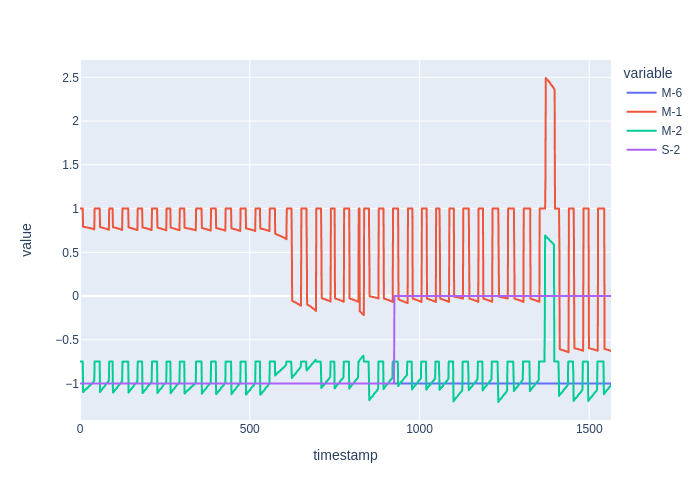

In [13]:
train_set = Image.open("/content/Anomalies-detection---Vector-workshop/images/train_explore.png")
train_set

### Loading and plotting test set with labeled_anomalies data

In [14]:
df_test= pd.read_csv('./data/msl/test.csv',sep=',')
labeled_anomalies= pd.read_csv('/content/Anomalies-detection---Vector-workshop/data/labeled_anomalies.csv',sep=',')

In [36]:
labeled_anomalies = labeled_anomalies[labeled_anomalies['spacecraft'] == 'MSL']
labeled_anomalies

,chan_id,spacecraft,anomaly_sequences,class,num_values
55,M-6,MSL,"[[1850, 2030]]",[point],2049
56,M-1,MSL,"[[1110, 2250]]",[contextual],2277
57,M-2,MSL,"[[1110, 2250]]",[contextual],2277
58,S-2,MSL,"[[900, 910]]",[point],1827
59,P-10,MSL,"[[4590, 4720]]",[point],6100
60,T-4,MSL,"[[1172, 1240]]",[point],2217
61,T-5,MSL,"[[1200, 1225]]",[point],2218
62,F-7,MSL,"[[1250, 1450], [2670, 2790], [3325, 3425]]","[contextual, contextual, contextual]",5054
63,M-3,MSL,"[[1250, 1500]]",[contextual],2127
64,M-4,MSL,"[[1250, 1500]]",[contextual],2038


In [16]:
df_test.head(5)

,timestamp,M-6,M-1,M-2,S-2,P-10,T-4,T-5,F-7,M-3,...,D-14,T-9,P-14,T-8,P-11,D-15,D-16,M-7,F-8,attack
0,0,-1.0,0.999906,-0.748738,-1.0,0.992941,0.0,-1.0,-0.892857,1.0,...,-1.0,0.639967,0.992941,-1.0,0.930975,-1.000000,-1.0,-0.999133,-1.000000,0.0
1,1,-1.0,0.999906,-0.748738,-1.0,0.993788,0.0,-1.0,-0.892857,1.0,...,-1.0,0.639967,0.993788,-1.0,0.918009,0.832485,-1.0,-0.999133,-0.565217,0.0
2,2,-1.0,0.999906,-0.748738,-1.0,0.993788,0.0,-1.0,-0.428571,1.0,...,-1.0,0.639967,0.993788,-1.0,0.927861,0.831559,-1.0,-0.999133,-1.000000,0.0
3,3,-1.0,0.999906,-0.748738,-1.0,0.994635,0.0,-1.0,-0.500000,1.0,...,-1.0,0.639967,0.994635,-1.0,0.921442,0.831559,-1.0,-0.999133,-1.000000,0.0
4,4,-1.0,0.999906,-0.748738,-1.0,0.994635,0.0,-1.0,-0.892857,1.0,...,-1.0,0.637897,0.994635,-1.0,0.916484,0.831559,-1.0,-0.999133,-1.000000,0.0


#### M-6 point anonymous

In [17]:
## M-6 is point anonymous, anomalies are highlighted with blue circles
plot_sensor_with_anomalies('M-6', df_test, labeled_anomalies, save_as = True,
                           filepath = '/content/Anomalies-detection---Vector-workshop/images/',
                           filename = 'test_explore_M6.png')

Save image to /content/Anomalies-detection---Vector-workshop/images/test_explore_M6.png


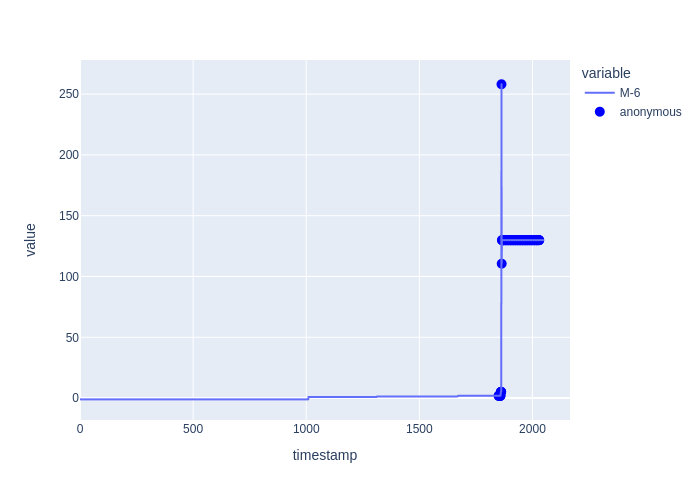

In [18]:
img_m6 = Image.open("/content/Anomalies-detection---Vector-workshop/images/test_explore_M6.png")
img_m6

#### M-2 contextual anonymous

In [19]:
## M-2 is contextual anonymous
plot_sensor_with_anomalies('M-2', df_test, labeled_anomalies, save_as = True,
                           filepath = '/content/Anomalies-detection---Vector-workshop/images/',
                           filename = 'test_explore_M2.png')

Save image to /content/Anomalies-detection---Vector-workshop/images/test_explore_M2.png


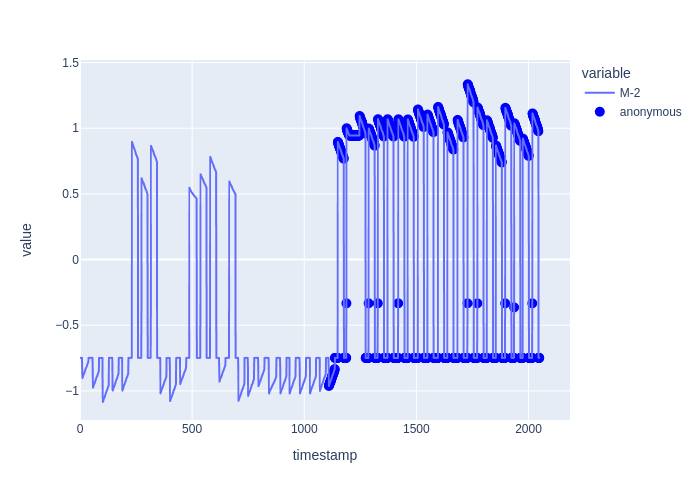

In [20]:
img_m2 = Image.open("/content/Anomalies-detection---Vector-workshop/images/test_explore_M2.png")
img_m2

#### S-2 point anonymous

In [21]:
## S-2 is point anonymous
plot_sensor_with_anomalies('S-2', df_test, labeled_anomalies, save_as = True,
                           filepath = '/content/Anomalies-detection---Vector-workshop/images/',
                           filename = 'test_explore_S2.png')

Save image to /content/Anomalies-detection---Vector-workshop/images/test_explore_S2.png


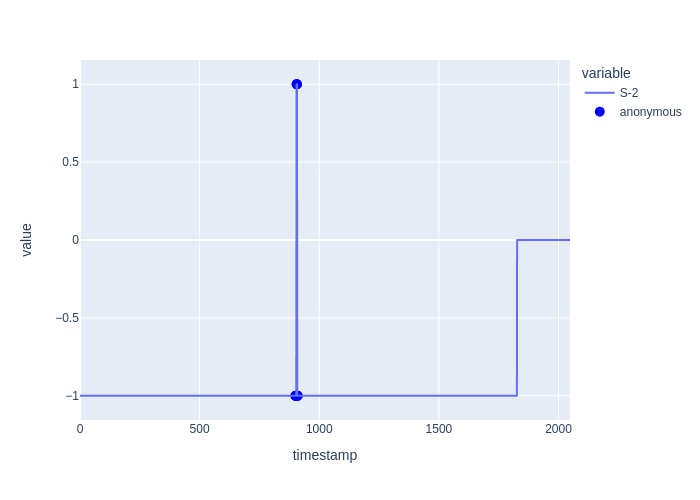

In [22]:
img_s2 = Image.open("/content/Anomalies-detection---Vector-workshop/images/test_explore_S2.png")
img_s2

##4. Model and run sample data

#### GDN architechture

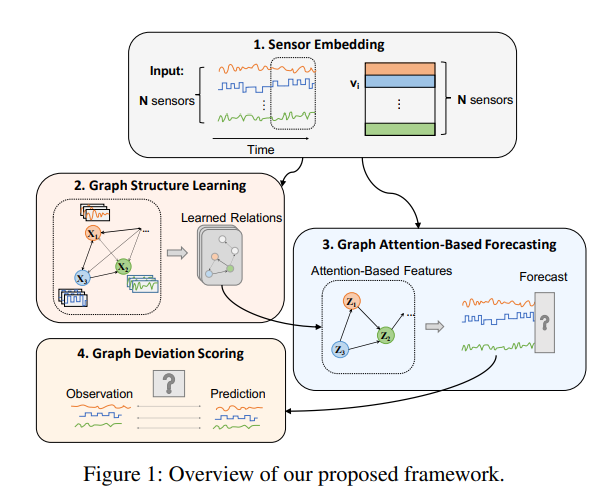

In [23]:
gdn_model = Image.open("/content/Anomalies-detection---Vector-workshop/GDN-model.png")
gdn_model

#### args and run sample
- arg[1] : 0 GPU
- arg[2] : dataset msl
- arg[3] : slide_window
- arg[4] : slide_stride
- arg[5] : epoch

In [63]:
!bash run.sh 0 msl 15 3 40

/content/GDN/models/GDN.py:161: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  gated_i = torch.arange(0, node_num).T.unsqueeze(1).repeat(1, topk_num).flatten().to(device).unsqueeze(0)
epoch (0 / 40) (Loss:0.67110572, ACU_loss:8.72437441)
epoch (1 / 40) (Loss:0.43080807, ACU_loss:5.60050488)
epoch (2 / 40) (Loss:0.35093824, ACU_loss:4.56219712)
epoch (3 / 40) (Loss:0.31127959, ACU_loss:4.04663470)
epoch (4 / 40) (Loss:0.28349104, ACU_loss:3.68538356)
epoch (5 / 40) (Loss:0.26525430, ACU_loss:3.44830592)
epoch (6 / 40) (Loss:0.23378914, ACU_loss:3.03925884)
epoch (7 / 40) (Loss:0.21440425, ACU_loss:2.78725529)
epoch (8 / 40) (Loss:0.21295913, ACU_loss:2.76846868)
epoch (9 / 40

#### Show the saved embedding figure

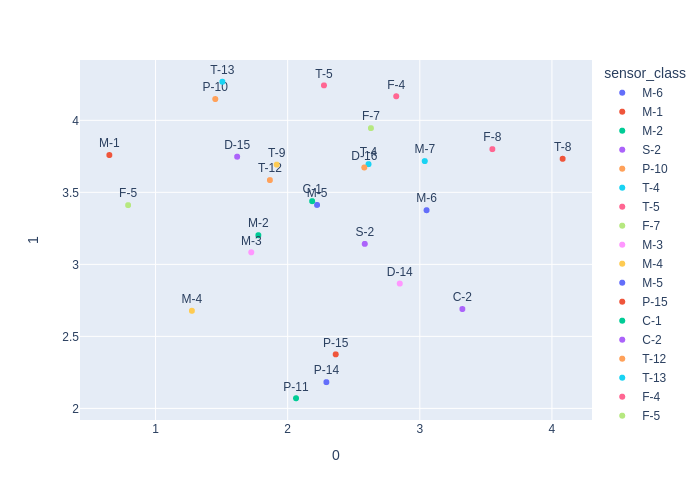

In [48]:
img_embeddings = Image.open("/content/Anomalies-detection---Vector-workshop/images/test_embedding.png")
img_embeddings

##5. Visualize the results

#### Plot predicted and ground true attack label

In [64]:
### load the predictions for each timestamp
path = '/content/Anomalies-detection---Vector-workshop/data/pred_labels.csv'
df = pd.read_csv(path)
df = df.rename(columns={"Unnamed: 0": "timestamp"})
df = df.set_index('timestamp')
df

,gt_label,pred_label
timestamp,,
0,0,0.0
1,0,0.0
2,0,0.0
3,0,1.0
4,0,1.0
...,...,...
2029,1,1.0
2030,1,1.0
2031,1,1.0


In [65]:
### compare the prediction and ground labels
cols = df.columns
ncols = len(cols)

# subplot setup
fig = make_subplots(rows=ncols, cols=1, shared_xaxes=True, vertical_spacing=0.03)

for i, col in enumerate(cols, start=1):
    fig.add_trace(go.Scatter(x=df[col].index, y=df[col].values, name=col), row=i, col=1)

fig.update_layout(title_text="Ground true label and predicted label")
fig.write_image('/content/Anomalies-detection---Vector-workshop/images/gt_pred_testLabel.png')
# fig.show()

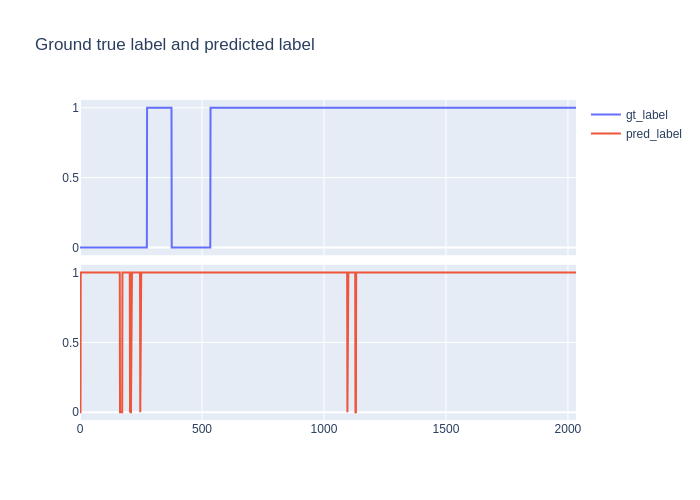

In [66]:
img_gt_pred = Image.open("/content/Anomalies-detection---Vector-workshop/images/gt_pred_testLabel.png")
img_gt_pred

#### Graph image

In [52]:
!pwd

/content/GDN


In [74]:
!python graph_visualization.py auto graph_v2.png

/content/GDN/models/GDN.py:161: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  gated_i = torch.arange(0, node_num).T.unsqueeze(1).repeat(1, topk_num).flatten().to(device).unsqueeze(0)
Central Node: D-15
Red Node: M-1
Red Node: P-10
Red Node: T-12
Red Node: T-9
Red Node: D-15


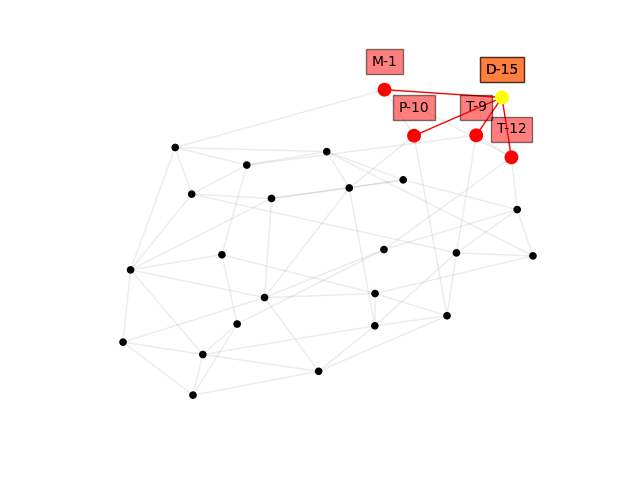

In [75]:
img_graph = Image.open("graph_v2.png")
img_graph

#### Compare the predictions for each sensor

In [76]:
#get sensors name
df_test_1 = df_test.drop(columns=['timestamp','attack'])
sensors_name = df_test_1.columns.tolist()

In [77]:
path = '/content/Anomalies-detection---Vector-workshop/data/pred_sensor.csv'
df_pred = pd.read_csv(path)
df_pred = df_pred.rename(columns={"Unnamed: 0": "timestamp"})
df_pred = df_pred.set_index('timestamp')
df_pred.columns = sensors_name
df_pred.head(5)

,M-6,M-1,M-2,S-2,P-10,T-4,T-5,F-7,M-3,M-4,...,F-5,D-14,T-9,P-14,T-8,P-11,D-15,D-16,M-7,F-8
timestamp,,,,,,,,,,,,,,,,,,,,,
0,-1.053554,0.678501,-0.958883,-1.105126,1.128921,-0.458283,-0.929623,-0.827259,0.340892,0.380047,...,-0.563002,-1.088395,0.072218,0.835175,-0.913020,0.756724,0.864694,-0.827731,-1.009262,-1.065349
1,-1.050149,0.763453,-0.941386,-1.089346,0.955520,-0.350382,-0.928421,-0.825804,0.305759,0.281065,...,-0.561519,-1.102171,0.064698,0.955742,-0.924327,0.785021,1.022451,-0.832032,-1.004260,-1.065942
2,-1.055029,0.873061,-0.919861,-1.083633,0.918436,-0.134159,-0.949749,-0.823990,0.324254,0.392493,...,-0.543460,-1.097184,0.107897,0.953946,-0.926072,0.829343,0.884883,-0.832960,-0.988765,-1.065946
3,-1.142845,0.780220,-0.903956,-1.058428,0.918601,0.008913,-0.950502,-0.524231,0.293991,0.347817,...,-0.537989,-1.086137,0.155413,0.932447,-0.849384,0.848122,0.917518,-0.746288,-0.955873,-0.365074
4,-1.060056,0.815857,-0.905905,-1.061918,0.872978,-0.233985,-0.941017,-0.645615,0.133546,-0.310494,...,-0.572046,-1.079669,0.134876,0.977744,-0.819682,0.800860,0.918055,-0.774221,-0.982331,-0.982406


In [78]:
path = '/content/Anomalies-detection---Vector-workshop/data/label_sensor.csv'
df_label = pd.read_csv(path)
df_label = df_label.rename(columns={"Unnamed: 0": "timestamp"})
df_label = df_label.set_index('timestamp')
df_label.columns = sensors_name
df_label.head(5)

,M-6,M-1,M-2,S-2,P-10,T-4,T-5,F-7,M-3,M-4,...,F-5,D-14,T-9,P-14,T-8,P-11,D-15,D-16,M-7,F-8
timestamp,,,,,,,,,,,,,,,,,,,,,
0,-1.0,1.617740,-0.880861,-1.0,0.995200,0.0,-1.0,-0.892857,0.188538,0.399145,...,-0.568362,-1.0,0.639967,0.995200,-1.000000,0.785172,0.825081,-1.0,-0.999133,-1.000000
1,-1.0,1.614925,-0.875566,-1.0,0.992941,0.0,-1.0,-0.857143,0.309036,0.410102,...,-0.565514,-1.0,0.639967,0.992941,-1.000000,0.765913,0.824156,-1.0,-0.999133,-1.000000
2,-1.0,1.612087,-0.870514,-1.0,0.993788,0.0,-1.0,-0.392857,0.445731,0.466619,...,-0.557421,-1.0,0.639967,0.993788,0.529412,0.704961,0.823230,-1.0,-0.999133,1.304348
3,-1.0,1.612087,-0.870514,-1.0,0.993506,0.0,-1.0,-0.428571,0.195023,-0.157092,...,-0.548128,-1.0,0.639967,0.993506,-1.000000,0.693584,0.835261,-1.0,-0.999133,-1.000000
4,-1.0,1.609237,-0.865324,-1.0,0.992658,-1.0,-1.0,-0.892857,0.403162,0.300222,...,-0.544007,-1.0,0.639967,0.992658,-1.000000,0.704834,0.842665,-1.0,-0.999133,-1.000000


In [79]:
plot_gtAndPred_sensor_with_anomalies('D-15', df_pred, df_label, labeled_anomalies, save_as = True,
                                     filepath = '/content/Anomalies-detection---Vector-workshop/images/',
                                     filename = 'pred_gt_D15.png')

Save image to /content/Anomalies-detection---Vector-workshop/images/pred_gt_D15.png


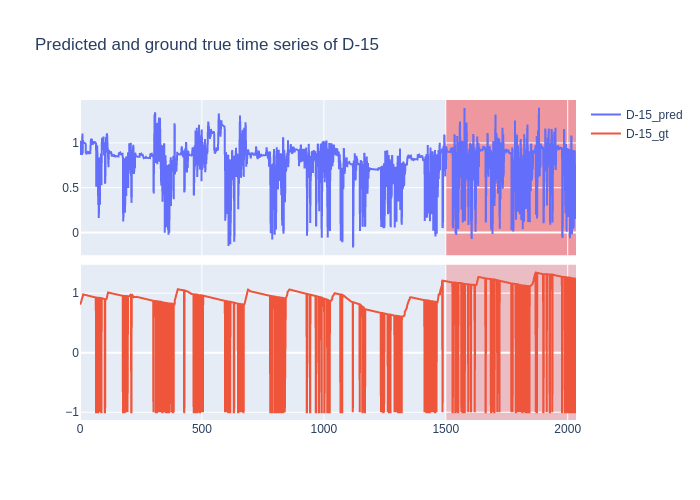

In [85]:
img_D15 = Image.open("/content/Anomalies-detection---Vector-workshop/images/pred_gt_D15.png")
img_D15

In [80]:
plot_gtAndPred_sensor_with_anomalies('M-1', df_pred, df_label, labeled_anomalies, save_as = True,
                                     filepath = '/content/Anomalies-detection---Vector-workshop/images/',
                                     filename = 'pred_gt_M1.png')

Save image to /content/Anomalies-detection---Vector-workshop/images/pred_gt_M1.png


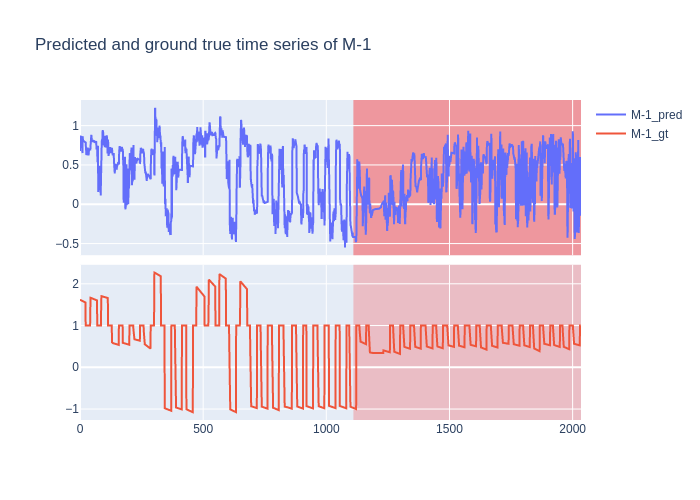

In [84]:
img_M1 = Image.open("/content/Anomalies-detection---Vector-workshop/images/pred_gt_M1.png")
img_M1

In [82]:
plot_gtAndPred_sensor_with_anomalies('T-12', df_pred, df_label, labeled_anomalies, save_as = True,
                                     filepath = '/content/Anomalies-detection---Vector-workshop/images/',
                                     filename = 'pred_gt_T12.png')

Save image to /content/Anomalies-detection---Vector-workshop/images/pred_gt_T12.png


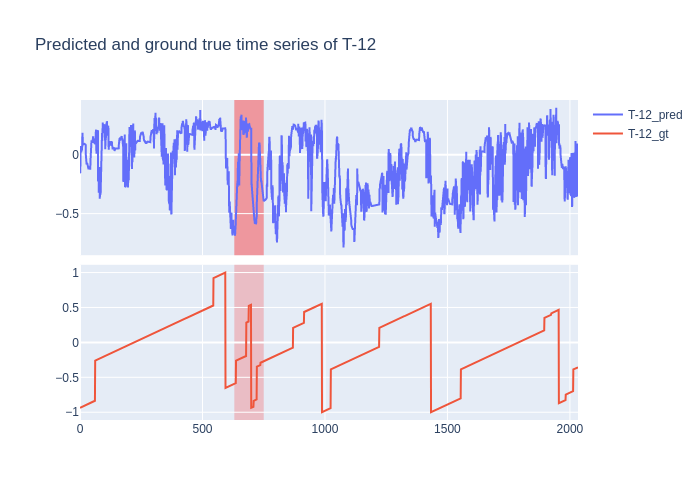

In [83]:
img_T12 = Image.open("/content/Anomalies-detection---Vector-workshop/images/pred_gt_T12.png")
img_T12

##6. Try with normalization of time series

In [ ]:
#copy TimeDataset.py
# %cp /content/Anomalies-detection---Vector-workshop/modified_pyFile/TimeDataset.py